# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>



# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) [Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change [Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Retrieve CMIP6 data through [Pangeo](https://pangeo-data.github.io/pangeo-cmip6-cloud/)
* Hybrid sigma-pressure coordinates to isobaric pressure levels of the European Centre for Medium-Range Weather Forecast Re-Analysis 5 (ERA5) with [GeoCAT-comb](https://geocat-comp.readthedocs.io/en/latest/index.html)
* Regridd the CMIP6 variables to the exact horizontal resolution with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate an ensemble mean of all used models
* Calculate and plot the seasonal mean of the ensemble mean

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?

> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **1985 to 2014**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. 

- Time period: 1985 to 2014
- horizonal resolution: ~100km
- time resolution: monthly atmospheric data (Amon, AERmon)
- Variables:
  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |    ml   |
| clivi         |    Ice Water Path                       | [kg m-2]      |         |
| lwp           |    Liquid Water Path                    | [kg m-2]      |         |
| pr            |    Precipitation                        | [kg m-2 s-1]  | surface |

- CMIP6 models:

| Institution                                            |     Model name    | Reference                                                     |
| ------------------------------------------------------ |:-----------------:|--------------------------------------------------------------:|
| [AS-RCEC](https://www.rcec.sinica.edu.tw/index_en.php) | TaiESM1           | [Lee et al. (2020)](https://doi.org/10.5194/gmd-13-3887-2020) |
| [BCC](http://bcc.ncc-cma.net/)                         | BCC-CSM2-M        | [Wu et al. (2019)](https://doi.org/10.5194/gmd-12-1573-2019)  |
| [CAMS](http://www.cma.gov.cn/en2014/)                  | CAMS-CSM1-0       |                                                               |
| [CAS](http://english.iap.cas.cn/)                      | FGOALS-f3-L       | [Bian et al. (2020)](https://doi-org.ezproxy.uio.no/10.1080/16742834.2020.1778419) |
| [CMCC](https://www.cmcc.it/)                           | CMCC-CM2-SR5      | [Cherchi et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001369)|
|                                                        | CMCC-CM2-HR4      | [Cherchi et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001369)|
|                                                        | CMCC-ESM2         | [CMCC website](https://www.cmcc.it/models/cmcc-esm-earth-system-model)    |
| [EC-Earth-Consortium](http://www.ec-earth.org/)        | EC-Earth3-AerChem | [van Noije et al. (2021)](https://doi.org/10.5194/gmd-14-5637-2021)  |
| [E3SM-Project](https://e3sm.org/)                      | E3SM-1-1          | [Golaz et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001603); [Burrows et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS001766) Text S8|
|                                                        | E3SM-1-1-ECA      | |
| [MPI-M](https://mpimet.mpg.de/en/homepage)             | MPI-ESM1-2-HR     | [Müller et al. (2018)](https://doi-org.ezproxy.uio.no/10.1029/2017MS001217)|
| [MRI](https://www.mri-jma.go.jp/index_en.html)         | MRI-ESM2-0        | [Yukimoto et al. (2019)](https://doi.org/10.2151/jmsj.2019-051) |
| [NCC](https://folk.uib.no/ngfhd/EarthClim/index.htm)   | NorESM2-MM        | [Seland et al. (2020)](https://doi.org/10.5194/gmd-13-6165-2020)|
| [NOAA-GFDL](https://www.gfdl.noaa.gov/)                | GFDL-CM4          | [Held et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2019MS001829) |
|                                                        | GFDL-ESM4         | [Dunne et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS002015) |
| [SNU](https://en.snu.ac.kr/index.html)                 | SAM0-UNICON       | [Park et al. (2019)](https://doi-org.ezproxy.uio.no/10.1175/JCLI-D-18-0796.1) |
| [THU](https://www.tsinghua.edu.cn/en/)                 | CIESM             | [Lin et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS002036) |


## Import python packages
- `Python` environment requirements: file [globalsnow.yml](../globalsnow.yml) 
- load `python` packages from [imports.py](../utils/imports.py)
- load `functions` from [functions.py](../utils/functions.py)

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
from imports import (xr, intake, cftime, xe, glob, np, cm, pd, fct,ccrs, cy, plt, da, gc)

xr.set_options(display_style="html")


# reload imports
%load_ext autoreload
%autoreload 2

## Open CMIP6 online catalog
... by using `intake` from [pangeo.io](https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html), specifically `intake-esm`.

An example on [Loading an ESM collection](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection) and [searching for datasets](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#searching-for-datasets) can also be found on the [Pangeo / ESGF Cloud Data Working Group documentation](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html).

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,523774
dcpp_init_year,60


## Search corresponding data
Get the data required for the analysis. Define variables, models, experiment, and time resolution as defined in <a href="#data_wrangling">2. Data Wrangling</a>
. 

* use member_id = 'r1i1p1f1'.
* using intake-esm’s `search()` function:
  * `col.search(variable_id, source_id, experiment_id, table_id, member_id, institution_id, grid_label)`

In [3]:
## Variables
variable_id=[
            # 'cli'
            # 'clivi',
            # 'clw'
            # 'lwp',
            # 'pr',
            'prsn',
            # 'ta', 
            # 'tas'
             ]

In [4]:
## Models
list_models = [
    'NorESM2-MM',
    'TaiESM1',
    'EC-Earth3-AerChem',
    'GFDL-ESM4',
    'SAM0-UNICON',
    'CAMS-CSM1-0',
    'CMCC-CM2-HR4',
    'MPI-ESM1-2-HR',
    'BCC-CSM2-MR',
    'E3SM-1-1',
    'CMCC-CM2-SR5',
    'CMCC-ESM2',
    'FGOALS-f3-L',
    'E3SM-1-1-ECA',
    'CIESM',
    'GFDL-CM4',
    'MRI-ESM2-0']  

In [5]:
## experiment
experiment_id = ['historical']

## time resolution
t_res = ['Amon', 'AERmon']

In [6]:
## search for variables, models, ...
cat = col.search(variable_id=variable_id[0], source_id=list_models, experiment_id=experiment_id, table_id = t_res, member_id=['r1i1p1f1'])
# cat.df
## show the CMIP6 models found in pandas Dataframe 
cat.df['source_id'].unique()

array(['GFDL-CM4', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'SAM0-UNICON',
       'MPI-ESM1-2-HR', 'GFDL-ESM4', 'FGOALS-f3-L', 'NorESM2-MM',
       'E3SM-1-1', 'E3SM-1-1-ECA', 'CMCC-CM2-SR5', 'TaiESM1',
       'EC-Earth3-AerChem', 'CMCC-CM2-HR4'], dtype=object)

## Create dictionary from the list of datasets we found
Load the found datasets into xarray dataset containers using intake-esm’s `to_dataset_dict()` function, which yields a Python dictionary.

> **_NOTE:_** This step may take several minutes so be patient!

In [7]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
# list all merged datasets and show coordinates
for keys, ds in dset_dict.items():
    print('{}: {}'.format(keys, list(ds.dims)))

CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1: ['bnds', 'lat', 'lon', 'member_id', 'time']
CMIP.AS-RCEC.TaiESM1.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.NCC.NorESM2-MM.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.SNU.SAM0-UNICON.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn: ['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn

## Calendar
Not all models in CMIP6 use the same calendar. Hence we double check the time axis. Later, when we regrid to the same horizontal resolution (<a href="#regrid_hz">Regrid CMIP6 data</a>) we will assign the same calendars for each model. 

In [9]:
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
_d2 = pd.DataFrame(_d2).rename(columns={0:'index'})
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():
        
        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)

_d2.dropna(how='all', axis=1, inplace=True)
_d2 = _d2.set_index('index')
_d2.columns = _d2.loc['parent_source_id']
_d2.drop('parent_source_id').T

index,calendar,branch_time_in_parent,parent_time_units
parent_source_id,,,
E3SM-1-1,noleap,0.0,days since 0001-01-01
GFDL-CM4,noleap,36500.0,days since 0001-1-1
TaiESM1,noleap,171550.0,days since 1850-01-01
E3SM-1-1-ECA,noleap,0.0,days since 0001-01-01
FGOALS-f3-L,noleap,12345.0,days since 0001-01-01
MPI-ESM1-2-HR,proleptic_gregorian,0.0,days since 1850-1-1 00:00:00
NorESM2-MM,noleap,438000.0,days since 0001-01-01
SAM0-UNICON,noleap,99645.0,days since 0001-01-01
CMCC-CM2-HR4,noleap,0.0,days since 1850-01-01


## Show attributes and individual identifier
NorESM2-MM is going to be the reference model for the horizontal grid. The `xarray` datasets inside `dset_dict` can be extracted as any value in a Python dictionary.

The dictonary key for NorESM2-MM is: **CMIP.NCC.NorESM2-MM.historical.Amon.gn**

In [10]:
if variable_id[0] == 'lwp':
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn']
else:
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
    

## attributes of the xarray dataset 
ds[variable_id[0]].attrs, ds.attrs['tracking_id']

({'cell_measures': 'area: areacella',
  'cell_methods': 'area: time: mean',
  'comment': 'At surface; includes precipitation of all forms of water in the solid phase',
  'history': "2019-11-25T21:55:13Z altered by CMOR: Converted type from 'd' to 'f'.",
  'long_name': 'Snowfall Flux',
  'original_name': 'PRECSC+PRECSL',
  'standard_name': 'snowfall_flux',
  'units': 'kg m-2 s-1'},
 'hdl:21.14100/554fb9db-fdc0-425c-ac68-146cba77f8cb\nhdl:21.14100/7235eb45-2da1-4bb8-bd16-467256066116\nhdl:21.14100/f2188a57-eff0-4ab9-8263-a6654349ee18\nhdl:21.14100/3fdefb99-9db8-44c1-9a51-885f6db62cfa\nhdl:21.14100/f50ff646-df59-4eac-8080-e5da16e5d778\nhdl:21.14100/2fde10fe-1e37-4a93-ac9c-a34b8de5a606\nhdl:21.14100/25d85a61-ac30-49cd-985b-66d121e4d388\nhdl:21.14100/a83c191a-d59b-4079-87f3-8caa874fce06\nhdl:21.14100/23263a30-65b9-4887-b46c-253af00861e6\nhdl:21.14100/cbea6d5b-68dd-4db8-9500-8e2d1bcf11be\nhdl:21.14100/457e8153-b9e8-4e0a-a339-4b0f37c2992d\nhdl:21.14100/28e89d10-aa46-4629-9f96-07eb18d42bcc\nhd

## Assign attributes to the variables

We will assign the attributes to the variables as in ERA5 to make CMIP6 and ERA5 variables comperable.

* [`cli`](http://clipc-services.ceda.ac.uk/dreq/u/dd916e3e2eca18cda5d9f81749d0c91c.html) and [`clw`](http://clipc-services.ceda.ac.uk/dreq/u/86b2b3318a73839edfafa9d46864aadc.html) in **kg kg-1** $\rightarrow$ Multiply by **1000** to get **g kg-1**
* [`clivi`](http://clipc-services.ceda.ac.uk/dreq/u/73c496f5669cc122cf1cddfe4df2a27a.html) and [`lwp`](http://clipc-services.ceda.ac.uk/dreq/u/e6b31a1928879fcd3c92fe7b592f070e.html) in **kg m-2** $\rightarrow$ Multiply by **1000** to get **g m-2**
* [`pr`](http://clipc-services.ceda.ac.uk/dreq/u/62f26742cf240c1b5169a5cd511196b6.html) and [`prsn`](http://clipc-services.ceda.ac.uk/dreq/u/051919eddec810e292c883205c944ceb.html) in **kg m-2 s-1** $\rightarrow$ Multiply by **86400** to get **mm day-1**


In [11]:
for keys in dset_dict.keys():
    if variable_id[0] == 'cli' or variable_id[0] == 'clw' or variable_id[0]  == 'clivi' or variable_id[0] == 'lwp':
        dset_dict[keys][variable_id[0]] = dset_dict[keys][variable_id[0]]*1000
        if variable_id[0] == 'cli':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'g kg-1', 'long_name': 'Mass Fraction of Cloud Ice', 'standard_name': 'mass_fraction_of_cloud_ice_in_air', 'comment': 'Includes both large-scale and convective cloud. This is calculated as the mass of cloud ice in the grid cell divided by the mass of air (including the water in all phases) in the grid cell. It includes precipitating hydrometeors ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean (interval: 5 minutes)', 'cell_measures': 'area: areacella',}
        if variable_id[0] == 'clw':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'g kg-1', 'long_name': 'Mass Fraction of Cloud Liquid Water', 'standard_name': 'mass_fraction_of_cloud_liquid_water_in_air', 'comment': 'Includes both large-scale and convective cloud. Calculate as the mass of cloud liquid water in the grid cell divided by the mass of air (including the water in all phases) in the grid cells. Precipitating hydrometeors are included ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
        if variable_id[0] == 'clivi':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Ice Water Path', 'comment': 'mass of ice water in the column divided by the area of the column (not just the area of the cloudy portion of the column). Includes precipitating frozen hydrometeors ONLY if the precipitating hydrometeor affects the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'} 
        if variable_id[0] == 'lwp':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Liquid Water Path', 'comment': 'The total mass of liquid water in cloud per unit area.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}

    if variable_id[0] == 'pr' or variable_id[0] == 'prsn':
        dset_dict[keys][variable_id[0]] = dset_dict[keys][variable_id[0]]*86400
        if variable_id[0] == 'pr':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Precipitation', 'comment': 'includes both liquid and solid phases','cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
        if variable_id[0] == 'prsn':
            dset_dict[keys][variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall', 'comment': 'At surface; includes precipitation of all forms of water in the solid phase', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
    

 ## Interpolate from CMIP6 hybrid sigma-pressure levels to ERA5 isobaric pressure levels

The vertical variables in the CMIP6 models are in hybrid sigma-pressure levels. Hence the vertical variable in the xarray datasets in `dset_dict` will be calculated by using the [GeoCAT-comb](https://geocat-comp.readthedocs.io/en/latest/index.html#) function to [interpolate data from hybrid-sigma levels to isobaric levels](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.interpolation.interp_hybrid_to_pressure.html#geocat.comp.interpolation.interp_hybrid_to_pressure).

The GeoCAT-comb function takes the following input:
* `data`:   Multidimensional data array, which holds hybrid-sigma levels and has a lev_dim coordinate.
* `ps`:     A multi-dimensional array of surface pressures (Pa), same time/space shape as data. Not all variables include the surface pressure, hence we will search the `Pangeo.io` catalog to find the surface pressure associated with the model. 
* `hyam`:     One-dimensional arrays containing the hybrid A coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `hybm`:     One-dimensional arrays containing the hybrid B coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `p0`:       Scalar numeric value equal to surface reference pressure (Pa). Defaults to 100000 Pa.
* `new_levels`: A one-dimensional array of output pressure levels (Pa). We will use the ERA5 37 pressure levels.


$$ P(i,j,k) = hyam(k) p0 + hybm(k) ps(i,j)$$


In [12]:
# load the levels from the ERA5 file and transfer to Pa
era_level = (xr.open_dataset('/scratch/franzihe/input/ERA5/monthly_means/0.25deg/clwc_Amon_ERA5_198501_198912.nc')['level'])*100

# interpolate 
if variable_id[0] == 'clw' or variable_id[0] == 'cli':
    for keys in dset_dict.keys():
        if ('ps' in list(dset_dict[keys].keys())) == False:     # valid for models which don't provide ps in the clw or cli dataset
            model = keys.split('.')[2]
            ds_ps = col.search(source_id=model, table_id = ['Amon', ], experiment_id=['historical'], variable_id=['ps','p0', ], member_id=['r1i1p1f1']).to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
            dset_dict[keys].update(ds_ps[keys], )
            dset_dict[keys]['ps'] = dset_dict[keys]['ps'].isel(member_id = 0)
            
            
        # Rename datasets with different naming convention for constant A
        if ('a' in list(dset_dict[keys].keys())) == False:
            dset_dict[keys] = dset_dict[keys].rename({'ap':'a', 'ap_bnds': 'a_bnds'})
                 
                
        # Convert the model level to isobaric levels
        #### a, b, ps, p0
        if ('a' in list(dset_dict[keys].keys())) == True and ('b' in list(dset_dict[keys].keys())) == True and ('p0' in list(dset_dict[keys].keys())) == True and ('ps' in list(dset_dict[keys].keys())) == True:
            dset_dict[keys]['{}_interp'.format(variable_id[0])] = gc.interpolation.interp_hybrid_to_pressure(data=dset_dict[keys][variable_id[0]].isel(member_id = 0), 
                                                                                                             ps=dset_dict[keys]['ps'],hyam=dset_dict[keys]['a'],
                                                                                                             hybm=dset_dict[keys]['b'],
                                                                                                             p0=dset_dict[keys]['p0'].values, 
                                                                                                             new_levels=(era_level).values, )
            # remove the variables needed for the calculation of the isobaric levels. If this step is not performed, 
            # the horizontal regridding will not be possible.
            dset_dict[keys] = dset_dict[keys].drop(('a', 'p0', 'b', 'ps', 'a_bnds', 'b_bnds', variable_id[0]))
            dset_dict[keys] = dset_dict[keys].rename({'{}_interp'.format(variable_id[0]):variable_id[0]})

        #### a, b, ps
        elif ('a' in list(dset_dict[keys].keys())) == True and ('b' in list(dset_dict[keys].keys())) == True and ('ps' in list(dset_dict[keys].keys())) == True and ('p0' in list(dset_dict[keys].keys())) == False:
            dset_dict[keys]['{}_interp'.format(variable_id[0])] = gc.interpolation.interp_hybrid_to_pressure(data=dset_dict[keys][variable_id[0]].isel(member_id=0), 
                                                                                                             ps=dset_dict[keys]['ps'],
                                                                                                             hyam=dset_dict[keys]['a'], 
                                                                                                             hybm=dset_dict[keys]['b'],
                                                                                                             p0=100000.0,
                                                                                                             new_levels=(era_level).values, )
            dset_dict[keys] = dset_dict[keys].drop(('a', 'b', 'ps', 'a_bnds', 'b_bnds', variable_id[0]))
            dset_dict[keys] = dset_dict[keys].rename({'{}_interp'.format(variable_id[0]):variable_id[0]})


## Regrid CMIP6 data to NorESM2-MM grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models. At the moment we have all historical data from the CMIP6 models. For this, we will have to extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year.

The CMIP6 high resolution models have approximately a nominal resolution of 100km. But not all have identical grid spacing. Hence we will make use of the python package `xesmf` and the documentation on [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings). 

NorESM2-MM will be the reference grid since we want to compare the models to the ERA5 data. The ERA5 data has a nominal resolution of 0.25deg and has been regridded to the same horizontal resolution as the NorESM2-MM in [the ERA5 Jupyter Notebook](../ERA5/ERA5_1985-2014.ipynb). 

$\rightarrow$ Define NorESM2-MM as the reference grid `ds_out`.

Create a new Python dictionary (`ds_gridded_dict`) with the regridded CMIP6 `xarray` datasets between 1985 an 2014. Save each regridded model to a `netcdf`, locally. 

> **_NOTE:_** This step may take several minutes!

In [13]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
if variable_id[0] == 'lwp':
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn'].isel(member_id = 0)
else:
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn'].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()


counter = 0

for keys in dset_dict.keys():
    # select only models which have atmospheric monthly values
    amon = keys.split('.')[-2]
    if amon == 'Amon' or amon == 'AERmon': 
        # select model name 
        model = keys.split('.')[2]
        
        # select where data should be saved
        filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
        savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/{}/'.format(model)
        nc_out = savepath + filename
        files = glob(nc_out)
        
        # Input data from CMIP6 model to be regridded
        ds_in = dset_dict[keys].isel(member_id = 0)
        ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
        # common time grid
        ds_in['time'] = ds_out['time']
            

        # Regrid data
        ds_in_regrid = fct.regrid_data(ds_in, ds_out)


        # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
        ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
        ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)
            
            
        # create dataset with all models
        ds_gridded_dict[model] = ds_in_regrid

        # if nc_out in files:
        #     print('{} is downloaded'.format(nc_out))
        #     counter += 1
        #     print('Have regridded in total: {:} files'.format(str(counter)))
        # else:    
            # Save to netcdf file
        ds_in_regrid.to_netcdf(nc_out)
        print('file written: {}'.format(nc_out))

prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/E3SM-1-1/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/GFDL-CM4/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/TaiESM1/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/E3SM-1-1-ECA/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/FGOALS-f3-L/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/MPI-ESM1-2-HR/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/NorESM2-MM/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/SAM0-UNICON/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/CMCC-CM2-HR4/prsn_Amon_1deg_198501_201412.nc
prsn True
file written: /s

## Connect all models into one Dataset with new coordinate 'model'

We will create a `xarray.Dataset` with all CMIP6 models, after the interpolation to the same horizonal (and vertical) resolution. This step will make the next steps easier, as we will not need the the full dictonary key and can just use the model name.

In [14]:
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_cmip = ds_cmip.drop('bnds')

# 3. Exploratory Data Analysis <a id='exploratory'></a>

## Create seasonal mean of all regridded models
...and plot seasonal mean of each individual model

In [15]:
ds_cmip[variable_id[0]+'_season_mean'] = ds_cmip[variable_id[0]].groupby('time.season').mean('time', keep_attrs=True)

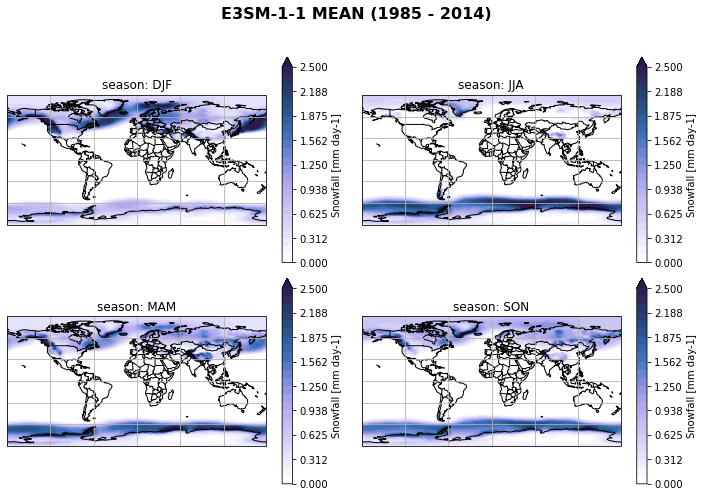

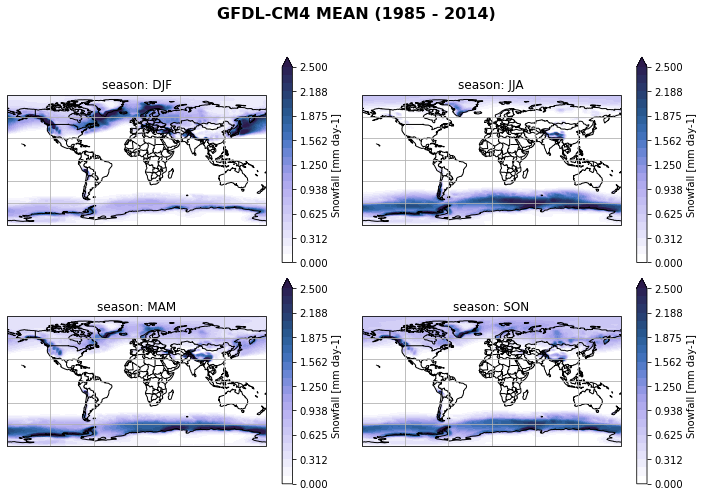

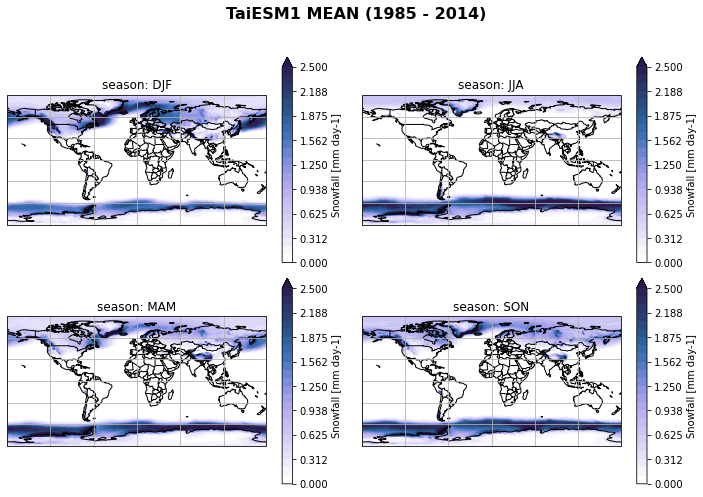

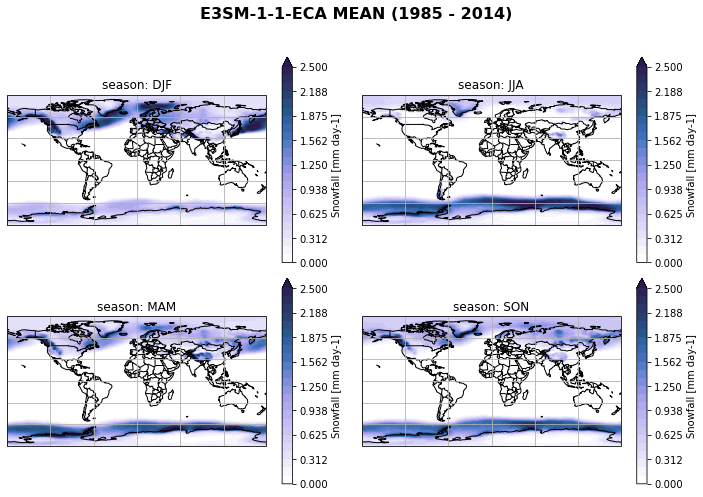

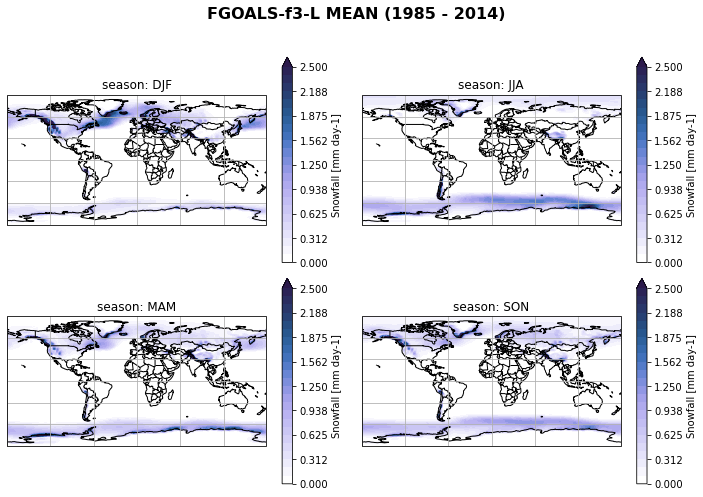

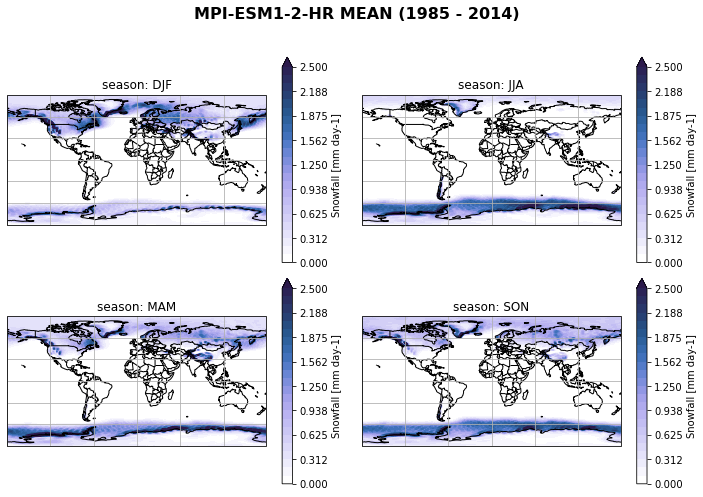

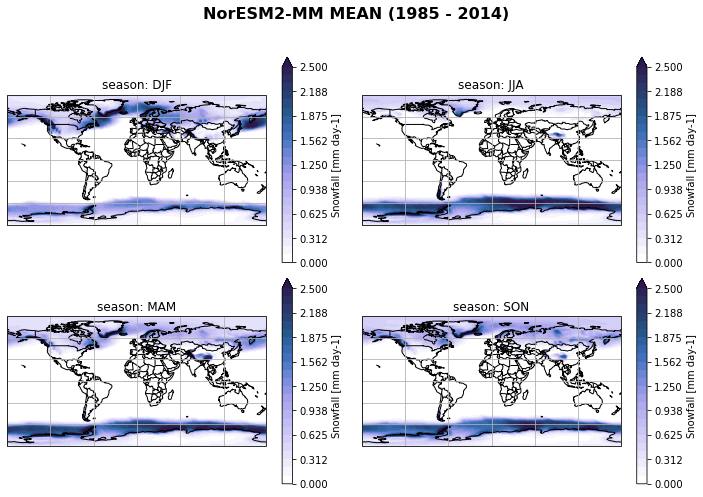

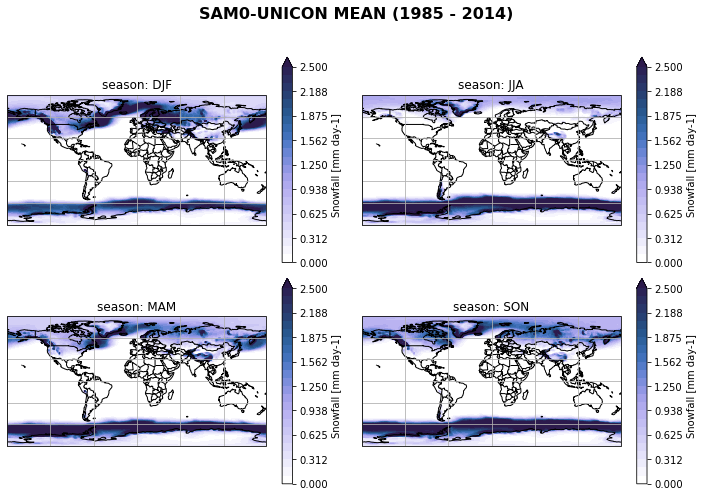

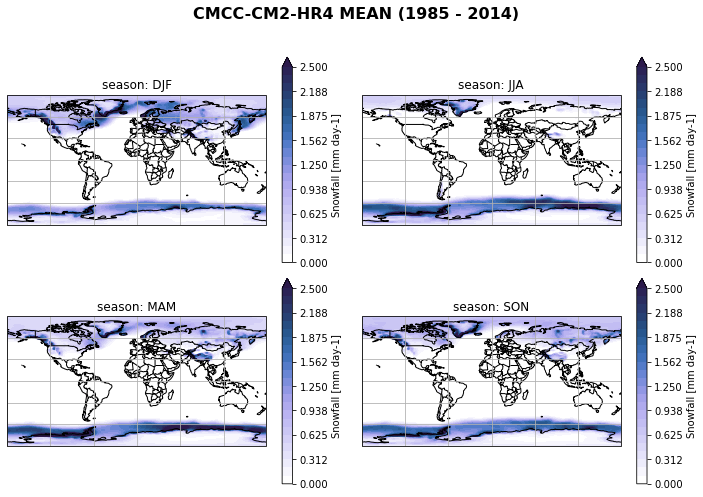

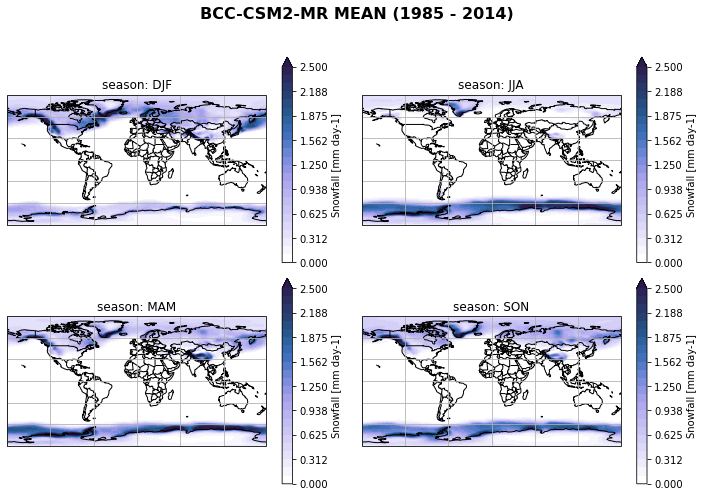

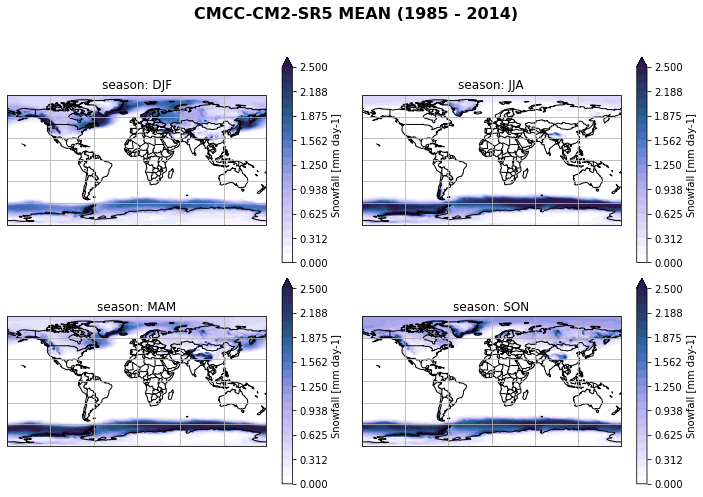

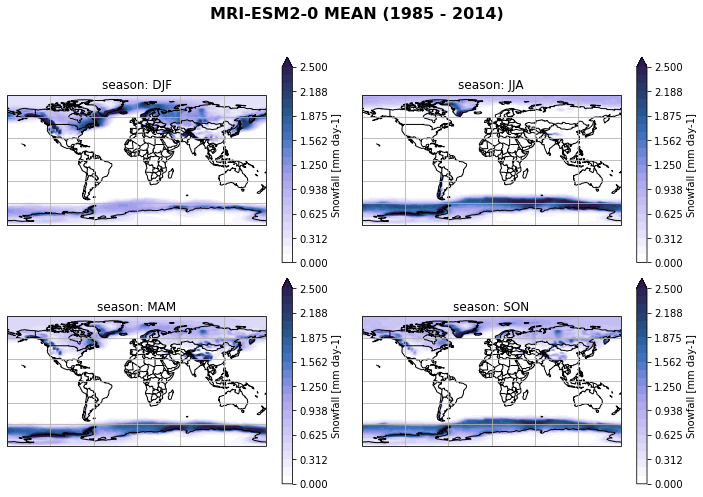

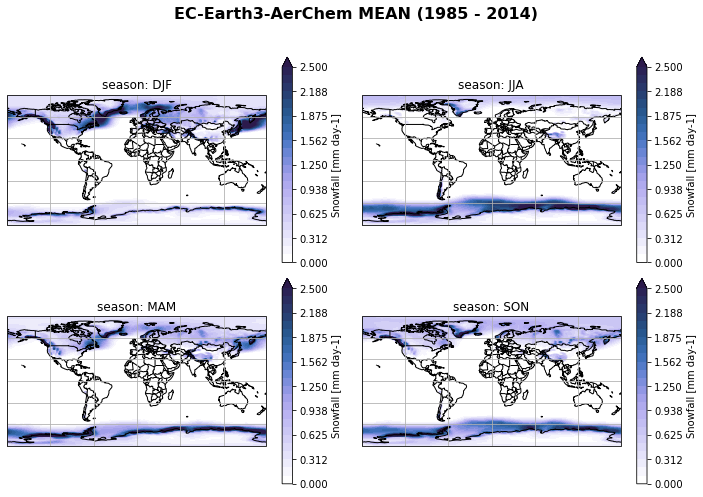

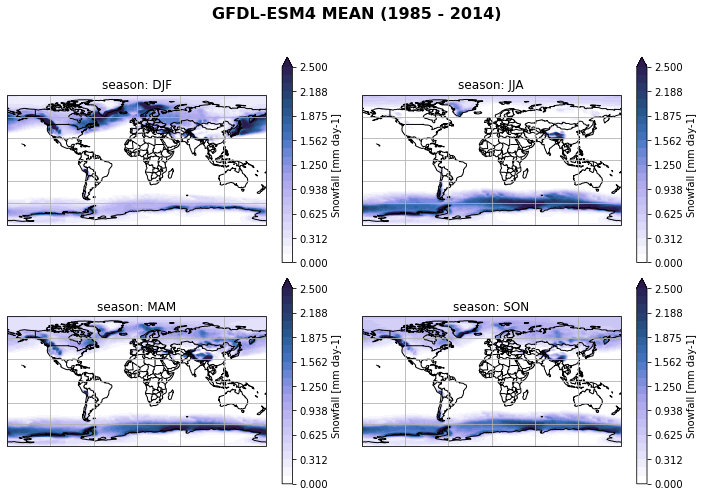

In [16]:
# extract the variable name similar to ERA5 for plotting
var = fct.to_era_variable[variable_id[0]]

for model in ds_cmip.model.values:
    fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_mean'].sel(model=model), var, title='{} MEAN ({} - {})'.format(model,starty, endy))

## Create model mean/spread of seasonal mean of all regridded models

In [17]:
ds_cmip[variable_id[0]+'_season_model_mean'] = ds_cmip[variable_id[0]+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[variable_id[0]+'_season_model_std']  = ds_cmip[variable_id[0]+'_season_mean'].std('model', keep_attrs=True, skipna = True)

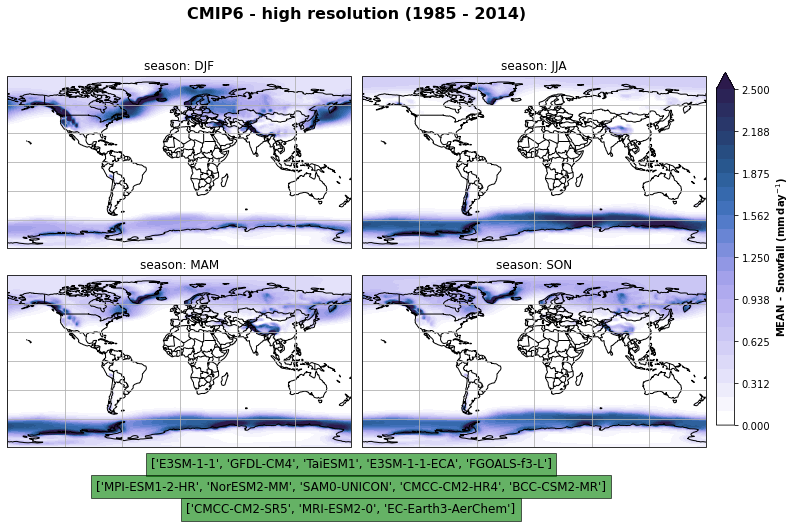

In [19]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_model_mean'], var, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')

plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
    

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

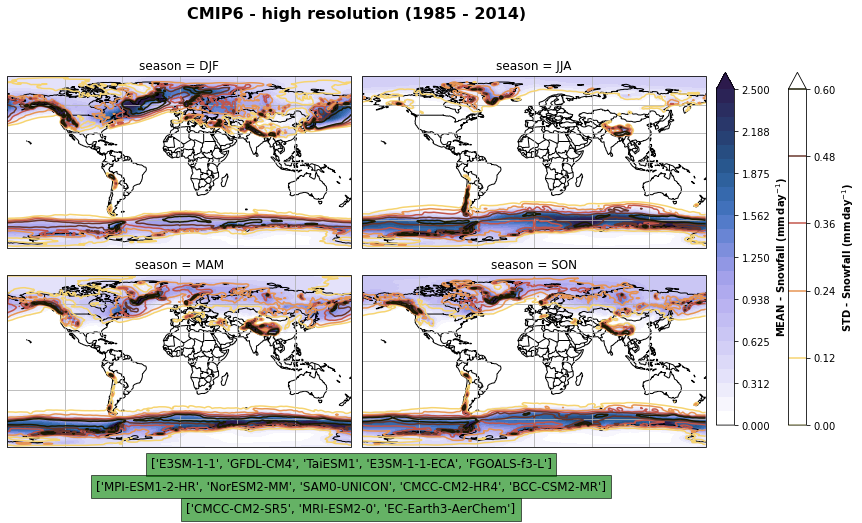

In [20]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_model_mean'], var, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')



for ax, i in zip(axs, ds_cmip[variable_id[0]+'_season_model_std'].season):
    sm = ds_cmip[variable_id[0]+'_season_model_std'].sel(season=i).plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = fct.plt_dict[var][fct.plt_dict['header'].index('vmin_std')], 
                                                                      vmax = fct.plt_dict[var][fct.plt_dict['header'].index('vmax_std')],
                                                                       levels = 6,
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    
cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
sb.set_label(label='STD - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')


plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_std_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [ ]:
# save to netcdf
filename = '{}_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/'
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
#     print('{} is downloaded'.format(nc_out))
#     counter += 1
#     print('Have saved in total: {:} files'.format(str(counter)))
# else:
    ds_cmip.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

# References <a id='references'></a>


[1] Zelinka, M. D., Myers, T. A., McCoy, D. T., Po-Chedley, S., Caldwell, P. M., Ceppi, P., et al. (2020). Causes of higher climate sensitivity in CMIP6 models. Geophysical Research Letters, 47, e2019GL085782. https://doi-org.ezproxy.uio.no/10.1029/2019GL085782 

[2] Bjordal, J., Storelvmo, T., Alterskjær, K. et al. Equilibrium climate sensitivity above 5 °C plausible due to state-dependent cloud feedback. Nat. Geosci. 13, 718–721 (2020). https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1 

[3] Wu, T., Lu, Y., Fang, Y., Xin, X., Li, L., Li, W., Jie, W., Zhang, J., Liu, Y., Zhang, L., Zhang, F., Zhang, Y., Wu, F., Li, J., Chu, M., Wang, Z., Shi, X., Liu, X., Wei, M., Huang, A., Zhang, Y., and Liu, X.: The Beijing Climate Center Climate System Model (BCC-CSM): the main progress from CMIP5 to CMIP6 , Geosci. Model Dev., 12, 1573–1600, https://doi.org/10.5194/gmd-12-1573-2019, 2019. 

[4] Lee, W.-L., Wang, Y.-C., Shiu, C.-J., Tsai, I., Tu, C.-Y., Lan, Y.-Y., Chen, J.-P., Pan, H.-L., and Hsu, H.-H.: Taiwan Earth System Model Version 1: description and evaluation of mean state, Geosci. Model Dev., 13, 3887–3904, https://doi.org/10.5194/gmd-13-3887-2020, 2020. 

[5] Bian HE, Yongqiang YU, Qing BAO, Pengfei LIN, Hailong LIU, Jinxiao LI, Lei WANG, Yimin LIU, Guoxiong WU, Kangjun CHEN, Yuyang GUO, Shuwen ZHAO, Xiaoqi ZHANG, Mirong SONG & Jinbo XIE (2020) CAS FGOALS-f3-L model dataset descriptions for CMIP6 DECK experiments, Atmospheric and Oceanic Science Letters, 13:6, 582-588, DOI: 10.1080/16742834.2020.1778419 

[6] Cherchi, A., Fogli, P. G., Lovato, T., Peano, D., Iovino, D., Gualdi, S., et al. (2019). Global mean climate and main patterns of variability in the CMCC-CM2 coupled model. Journal of Advances in Modeling Earth Systems, 11, 185– 209. https://doi-org.ezproxy.uio.no/10.1029/2018MS001369 

[7] van Noije, T., Bergman, T., Le Sager, P., O'Donnell, D., Makkonen, R., Gonçalves-Ageitos, M., Döscher, R., Fladrich, U., von Hardenberg, J., Keskinen, J.-P., Korhonen, H., Laakso, A., Myriokefalitakis, S., Ollinaho, P., Pérez García-Pando, C., Reerink, T., Schrödner, R., Wyser, K., and Yang, S.: EC-Earth3-AerChem: a global climate model with interactive aerosols and atmospheric chemistry participating in CMIP6 , Geosci. Model Dev., 14, 5637–5668, https://doi.org/10.5194/gmd-14-5637-2021, 2021. 

[8] Golaz, J.-C., Caldwell, P. M., Van Roekel, L. P., Petersen, M. R., Tang, Q., Wolfe, J. D., et al. (2019). The DOE E3SM coupled model version 1: Overview and evaluation at standard resolution. Journal of Advances in Modeling Earth Systems, 11, 2089– 2129. https://doi-org.ezproxy.uio.no/10.1029/2018MS001603 

[9] Burrows, S. M., Maltrud, M., Yang, X., Zhu, Q., Jeffery, N., Shi, X., et al. (2020). The DOE E3SM v1.1 biogeochemistry configuration: Description and simulated ecosystem-climate responses to historical changes in forcing. Journal of Advances in Modeling Earth Systems, 12, e2019MS001766. https://doi-org.ezproxy.uio.no/10.1029/2019MS001766 

[10] Müller, W. A., Jungclaus, J. H., Mauritsen, T., Baehr, J., Bittner, M., Budich, R., et al. (2018). A higher-resolution version of the Max Planck Institute Earth System Model (MPI-ESM1.2-HR). Journal of Advances in Modeling Earth Systems, 10, 1383– 1413. https://doi-org.ezproxy.uio.no/10.1029/2017MS001217 

[11] Yukimoto, S., H. Kawai, T. Koshiro, N. Oshima, K. Yoshida, S. Urakawa, H. Tsujino, M. Deushi, T. Tanaka, M. Hosaka, S. Yabu, H. Yoshimura, E. Shindo, R. Mizuta, A. Obata, Y. Adachi, and M. Ishii, 2019: The Meteorological Research Institute Earth System Model version 2.0, MRI-ESM2.0: Description and basic evaluation of the physical component. J. Meteor. Soc. Japan, 97, 931–965, doi:10.2151/jmsj.2019-051.

[12] Seland, Ø., Bentsen, M., Olivié, D., Toniazzo, T., Gjermundsen, A., Graff, L. S., Debernard, J. B., Gupta, A. K., He, Y.-C., Kirkevåg, A., Schwinger, J., Tjiputra, J., Aas, K. S., Bethke, I., Fan, Y., Griesfeller, J., Grini, A., Guo, C., Ilicak, M., Karset, I. H. H., Landgren, O., Liakka, J., Moseid, K. O., Nummelin, A., Spensberger, C., Tang, H., Zhang, Z., Heinze, C., Iversen, T., and Schulz, M.: Overview of the Norwegian Earth System Model (NorESM2) and key climate response of CMIP6 DECK, historical, and scenario simulations, Geosci. Model Dev., 13, 6165–6200, https://doi.org/10.5194/gmd-13-6165-2020, 2020. 

[13] Held, I. M., Guo, H., Adcroft, A., Dunne, J. P., Horowitz, L. W., Krasting, J., et al. (2019). Structure and performance of GFDL's CM4.0 climate model. Journal of Advances in Modeling Earth Systems, 11, 3691– 3727. https://doi-org.ezproxy.uio.no/10.1029/2019MS001829 

[14] Dunne, J. P., Horowitz, L. W., Adcroft, A. J., Ginoux, P., Held, I. M., John, J. G., et al. (2020). The GFDL Earth System Model Version 4.1 (GFDL-ESM 4.1): Overall coupled model description and simulation characteristics. Journal of Advances in Modeling Earth Systems, 12, e2019MS002015. https://doi-org.ezproxy.uio.no/10.1029/2019MS002015 

[15] Park, S., Shin, J., Kim, S., Oh, E., & Kim, Y. (2019). Global Climate Simulated by the Seoul National University Atmosphere Model Version 0 with a Unified Convection Scheme (SAM0-UNICON), Journal of Climate, 32(10), 2917-2949. Retrieved Jan 12, 2022, from https://journals-ametsoc-org.ezproxy.uio.no/view/journals/clim/32/10/jcli-d-18-0796.1.xml

[16] Lin, Y., Huang, X., Liang, Y., Qin, Y., Xu, S., & Huang, W., et al. (2020). Community Integrated Earth System Model (CIESM): Description and evaluation. Journal of Advances in Modeling Earth Systems, 12, e2019MS002036. https://doi-org.ezproxy.uio.no/10.1029/2019MS002036 